In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from collections import Counter, defaultdict

import MeCab
from gensim.models import word2vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm, tqdm_pandas, tqdm_notebook

In [2]:
with open("News_dataset.pickle", "rb") as data:
    df = pickle.load(data)
df = df.reset_index(drop=True)

df["Content_Parsed_1"] = df["Article"].str.replace("キーワードで気になるニュースを絞りこもう 「いいね」、フォローをしておすすめの記事をチェックしよう。 グノシーについて 公式SNS 関連サイト アプリをダウンロード グノシー | 情報を世界中の人に最適に届ける Copyright © Gunosy Inc. All rights reserved.", '')


In [3]:
def get_wakati_text(text):
    tagger = MeCab.Tagger("-Owakati")
    wakati_text = tagger.parse(text).strip()
    return wakati_text

nrows = len(df)
wakati_text_list = []
for row in range(0, nrows):
    
    text = df.loc[row]["Content_Parsed_1"]
    wakati_text_list.append(get_wakati_text(text))

df["wakati_text"] = wakati_text_list

# RandomForest Algorithm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import interp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

def get_RandSearchCV(X_train, y_train, X_test, y_test, scoring):
    from sklearn.model_selection import TimeSeriesSplit
    from datetime import datetime as dt 
    st_t = dt.now()
    # Numer of trees are used
    n_estimators = [5, 10, 50, 100, 150, 200, 250, 300]
    #n_estimators = list(np.arange(100,1000,50))
    #n_estimators = [1000]
    
    # Maximum depth of each tree
    max_depth = [5, 10, 25, 50, 75, 100]
    
    # Minimum number of samples per leaf 
    min_samples_leaf = [1, 2, 4, 8, 10]
    
    # Minimum number of samples to split a node
    min_samples_split = [2, 4, 6, 8, 10]
    
    # Maximum numeber of features to consider for making splits
    max_features = ["auto", "sqrt", "log2", None]
    
    hyperparameter = {'n_estimators': n_estimators,
                      'max_depth': max_depth,
                      'min_samples_leaf': min_samples_leaf,
                      'min_samples_split': min_samples_split,
                      'max_features': max_features}
    
    cv_timeSeries = TimeSeriesSplit(n_splits=5).split(X_train)
    base_model_rf = RandomForestClassifier(criterion="gini", random_state=42)
    
    # Run randomzed search 
    n_iter_search = 30
    
    rsearch_cv = RandomizedSearchCV(estimator=base_model_rf, 
                                   random_state=42,
                                   param_distributions=hyperparameter,
                                   n_iter=n_iter_search,
                                   cv=cv_timeSeries,
                                   scoring=scoring,
                                   n_jobs=-1)
    
    rsearch_cv.fit(X_train, y_train)
    #f = open("output.txt", "a")
    print("Best estimator obtained from CV data: \n", rsearch_cv.best_estimator_)
    print("Best Score: ", rsearch_cv.best_score_)
    return rsearch_cv

def evaluate_multiclass(best_clf, X_train, y_train, X_test, y_test, 
                        model="Random Forest", num_class=3):
    print("-"*100)
    print("~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Detailed report for the {} algorithm".format(model))
    
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    y_pred_prob = best_clf.predict_proba(X_test)
    
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print("The number of accurate predictions out of {} data points on unseen data is {}".format(
            X_test.shape[0], points))
    print("Accuracy of the {} model on unseen data is {}".format(
            model, np.round(test_accuracy, 2)))
    
    print("Precision of the {} model on unseen data is {}".format(
            model, np.round(metrics.precision_score(y_test, y_pred, average="macro"), 4)))
    print("Recall of the {} model on unseen data is {}".format(
           model, np.round(metrics.recall_score(y_test, y_pred, average="macro"), 4)))
    print("F1 score of the {} model on unseen data is {}".format(
            model, np.round(metrics.f1_score(y_test, y_pred, average="macro"), 4)))
    
    print("\nClassification report for {} model: \n".format(model))
    print(metrics.classification_report(y_test, y_pred))
    
    plt.figure(figsize=(15,15))
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    print("\nThe Confusion Matrix: \n")
    print(cnf_matrix)
    
    cmap = plt.cm.Blues
    sns.heatmap(cnf_matrix_norm, annot=True, cmap=cmap, fmt=".2f", annot_kws={"size":15})
    plt.title("The Normalized Confusion Matrix", fontsize=20)
    plt.ylabel("True label", fontsize=15)
    plt.xlabel("Predicted label", fontsize=15)
    plt.show()
    
    print("\nROC curve and AUC")
    y_pred = best_clf.predict(X_test)
    y_pred_prob = best_clf.predict_proba(X_test)
    y_test_cat = np.array(pd.get_dummies(y_test))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_class):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_cat[:,i], y_pred_prob[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= num_class
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(15,15))
    plt.plot(fpr["macro"], tpr["macro"], 
         label = "macro-average ROC curve with AUC = {} - Accuracy = {}%".format(
                 round(roc_auc["macro"], 2), round(test_accuracy, 2)),
         color = "navy", linestyle=":", linewidth=4)
    #colors = cycle(["red", "orange", "blue", "pink", "green"])
    colors = sns.color_palette()
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label = "ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]))   
    plt.plot([0,1], [0,1], "k--", lw=3, color='red')
    plt.title("ROC-AUC for {} model".format(model), fontsize=20)
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred, y_pred_prob

## RandomForest Algorithm for IF-IDF

In [13]:

vectorizer = TfidfVectorizer(use_idf = True, token_pattern=u'(?u)\\b\\w+\\b')
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()

y = df["Category"].apply(lambda x: 0 
                             if x == "エンタメ" else 1 
                             if x == "スポーツ" else 2
                             if x == "グルメ" else 3
                             if x == "海外" else 4 
                             if x == "おもしろ" else 5
                             if x == "国内" else 6
                             if x == "IT・科学" else 7)
X.shape

(3040, 54649)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
print("Starting Cross Validation steps...")
rsearch_cv = get_RandSearchCV(X_train, y_train, X_test, y_test, "f1_macro")

Starting Cross Validation steps...
Best estimator obtained from CV data: 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=75, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Best Score:  0.9994505494505495


----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~
Detailed report for the Random Forest algorithm
The number of accurate predictions out of 912 data points on unseen data is 912
Accuracy of the Random Forest model on unseen data is 100.0
Precision of the Random Forest model on unseen data is 1.0
Recall of the Random Forest model on unseen data is 1.0
F1 score of the Random Forest model on unseen data is 1.0

Classification report for Random Forest model: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00       124
           2       1.00      1.00      1.00       112
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00       110
           5       1.00      1.00      1.00       116
           6       1.00      1.00      1.0

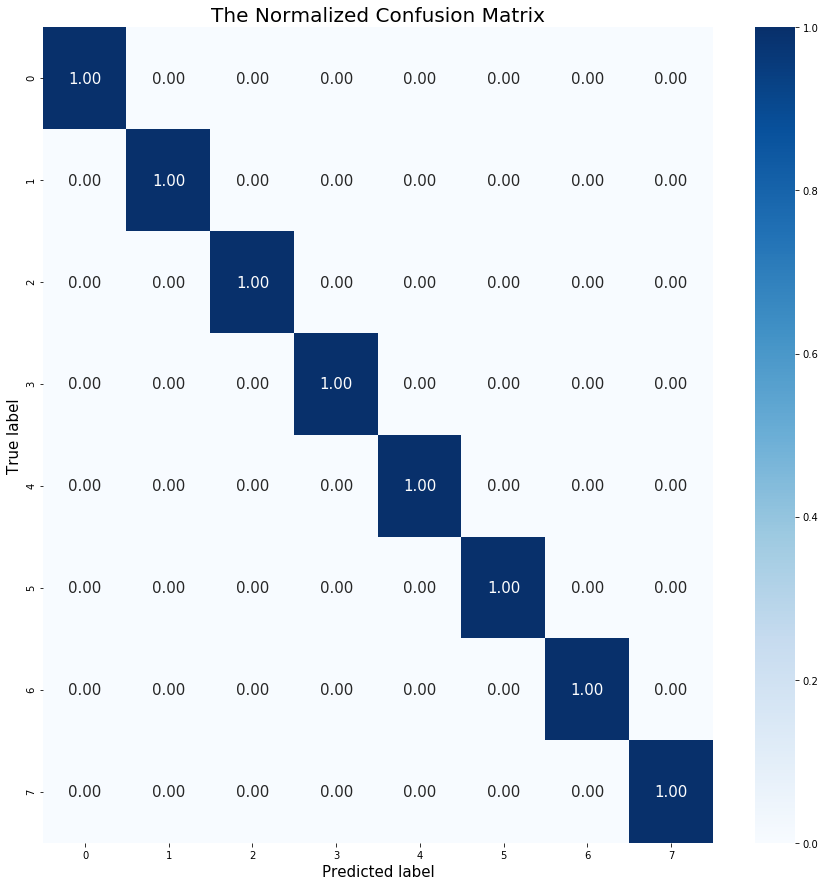


ROC curve and AUC


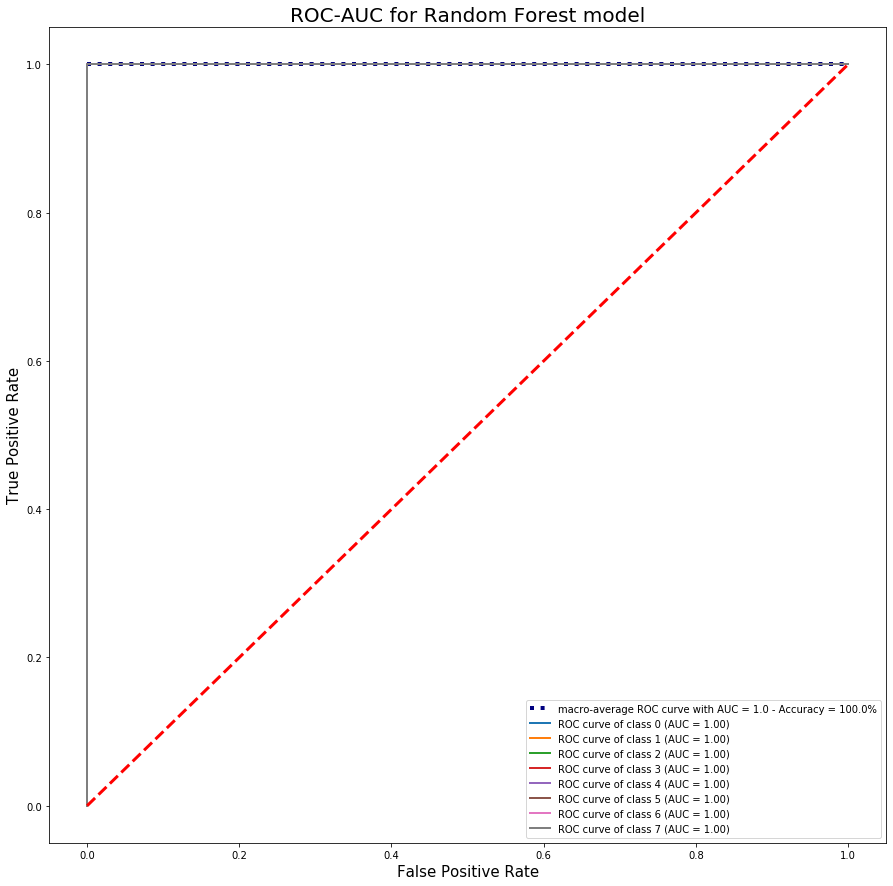

In [6]:
random_forest = rsearch_cv.best_estimator_
random_forest.fit(X_train, y_train)
y_pred, y_pred_prob = evaluate_multiclass(random_forest, X_train, y_train, X_test, y_test, 
                        model="Random Forest", num_class=8)

In [7]:
import json
import joblib

joblib.dump(random_forest, "./rf_classifier.joblib", compress=True)

['./rf_classifier.joblib']

## RandomForest Algorithm for Word2Vec

In [8]:
def get_doc_swem_max_vector(doc, model):
    words = doc.split()
    word_cnt = 0
    vector_size = model.vector_size
    doc_vector = np.zeros((len(words), vector_size))
    
    for i, word in enumerate(words):
        try:
            word_vector = model.wv[word]
        except KeyError:
            word_vector = np.zeros(vector_size)
        
        doc_vector[i, :] = word_vector
    
    doc_vector = np.max(doc_vector, axis=0)
    return doc_vector

def get_doc_mean_vector(doc, model):
    doc_vector = np.zeros(model.vector_size)
    words = doc.split()
    word_cnt = 0 
    for word in words:
        try:
            word_vector = model.wv[word]
            doc_vector += word_vector 
            word_cnt += 1
        except KeyError:
            pass
    doc_vector /= word_cnt 
    return doc_vector

In [9]:
corpus = [doc.split() for doc in df.wakati_text.values]
model_w2v = word2vec.Word2Vec(corpus, size=1000, min_count=20, window=10)
X = np.zeros((len(df), model_w2v.wv.vector_size))

for i, doc in tqdm_notebook(enumerate(df.wakati_text.values)):
    X[i, :] = get_doc_mean_vector(doc, model_w2v)

In [10]:
y = df["Category"].apply(lambda x: 0 
                             if x == "エンタメ" else 1 
                             if x == "スポーツ" else 2
                             if x == "グルメ" else 3
                             if x == "海外" else 4 
                             if x == "おもしろ" else 5
                             if x == "国内" else 6
                             if x == "IT・科学" else 7)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
print("Starting Cross Validation steps...")
rsearch_cv = get_RandSearchCV(X_train, y_train, X_test, y_test, "f1_macro")

Starting Cross Validation steps...
Best estimator obtained from CV data: 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Best Score:  0.9737396449791342


----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~
Detailed report for the Random Forest algorithm
The number of accurate predictions out of 912 data points on unseen data is 898
Accuracy of the Random Forest model on unseen data is 98.46
Precision of the Random Forest model on unseen data is 0.9852
Recall of the Random Forest model on unseen data is 0.9842
F1 score of the Random Forest model on unseen data is 0.9846

Classification report for Random Forest model: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       127
           1       1.00      0.98      0.99       124
           2       1.00      0.97      0.99       112
           3       0.98      1.00      0.99       114
           4       1.00      1.00      1.00       110
           5       0.97      0.97      0.97       116
           6       0.99      0.99

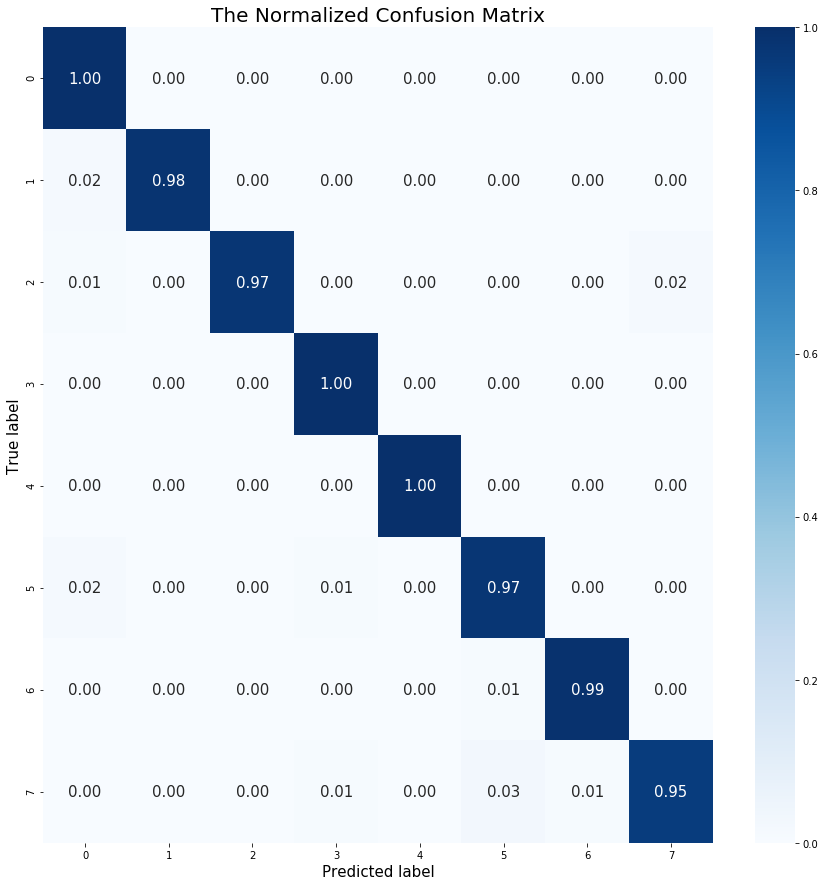


ROC curve and AUC


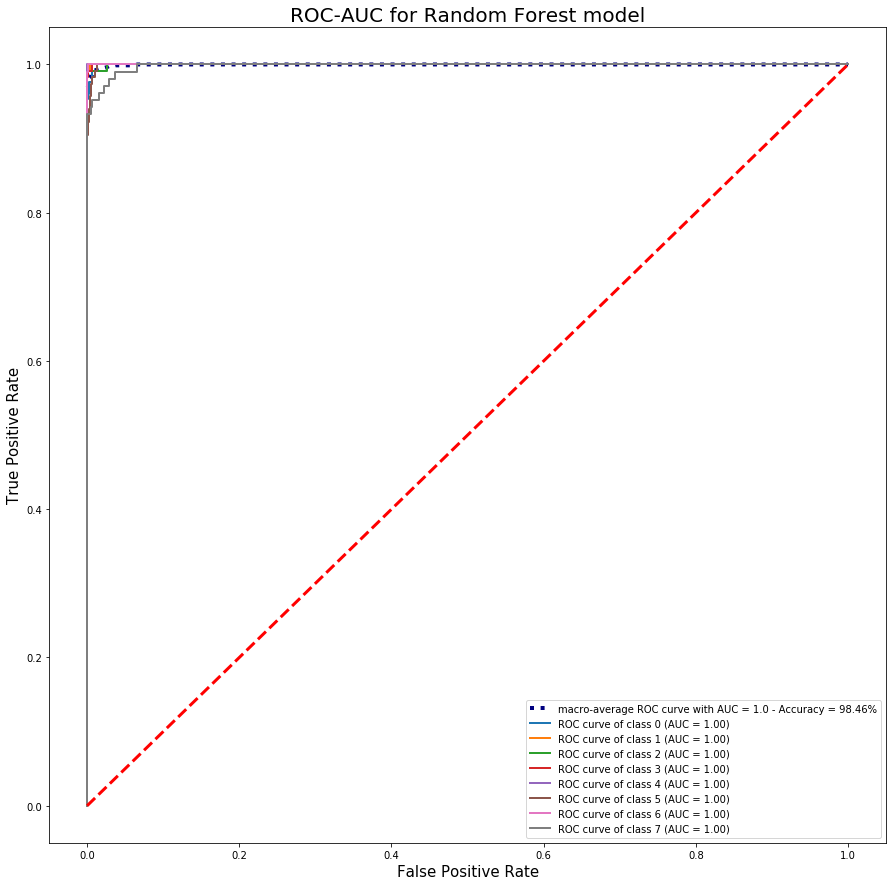

In [12]:
random_forest = rsearch_cv.best_estimator_
random_forest.fit(X_train, y_train)
y_pred, y_pred_prob = evaluate_multiclass(random_forest, X_train, y_train, X_test, y_test, 
                        model="Random Forest", num_class=8)